In [1]:
#img size
TRAIN_IMG_SIZE = (512, 512, 3)
VAL_IMG_SIZE = TRAIN_IMG_SIZE
TEST_IMG_SIZE = TRAIN_IMG_SIZE

'''
    00 background
    01 avalanche
    02 building_undamaged
    03 building_damaged
    04 cracks / fissure / subsidence"
    05 debris / mud / rock flow
    06 fire / flare
    07 flood / water / river / sea
    08 ice_jam_flow
    09 lava_flow
    10 person
    11 pyroclastic_flow
    12 road / railway / bridge
    13 vehicle
'''
N_CLASSES = 14

#batch
TRAIN_BATCH_SIZE = 2
VAL_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = 1


# number of workers in data loader
# how many work in each one epoch 
TRAIN_NUM_WORKERS = TRAIN_BATCH_SIZE
VAL_NUM_WORKERS = VAL_BATCH_SIZE
TEST_NUM_WORKERS = 1

NUM_EPOCHS = 200

PIN_MEMORY = True
LEARNING_RATE = 0.001

DEVICE = 'cuda'

# if you have LOAD model
# then you can try 'True'
LOAD_MODEL = False

# if you try more train
# and then you can select START_EPOCH number
START_EPOCH = 1

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import torch
import segmentation_models_pytorch as smp
import torchsummary as summary
import torchmetrics


from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from ignite.metrics import *
from tqdm import tqdm


torch.set_default_dtype(torch.float32)

torch.backends.cudnn.benchmark = True

In [3]:
df = pd.DataFrame(columns=['folder_path','image_name', 'extension'])

In [4]:
data_train_img_path = "./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/IMG/train/"
data_train_gt_path = './dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/GT/train/'
data_val_img_path = "./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/val/"
data_val_gt_path = './dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val/'

In [5]:
for img in os.listdir(data_train_img_path):
    info = {
        'folder_path': [data_train_img_path],
        #train name example is train_0000 (10 word)
        'image_name': [img[0:10]], 
        'extension': ['png']}
    info_ = pd.DataFrame(data=info)
    df = pd.concat((df, info_))

In [6]:

df = df.drop_duplicates(subset=['image_name'])

imgs = df.iloc[:,0] + df.iloc[:,1] + '.png'
imgs = imgs.reset_index(drop=True)
imgs

0       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
2       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
3       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
4       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
                              ...                        
1016    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1017    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1018    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1019    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1020    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
Length: 1021, dtype: object

In [7]:
labels = data_train_gt_path + df.iloc[:,1] + '.png'
labels = labels.reset_index(drop=True)

labels

0       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
2       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
3       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
4       ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
                              ...                        
1016    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1017    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1018    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1019    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
1020    ./dataset/LPCVC_Train/LPCVC_Train/LPCVC_Train/...
Name: image_name, Length: 1021, dtype: object

In [8]:
# img and label dataframe concat
train_df = pd.concat((imgs,labels),axis=1)

In [9]:
df = pd.DataFrame(columns=['folder_path','image_name'])

for img in os.listdir(data_val_img_path):
    info = {
        'folder_path': [data_val_img_path], 
        'image_name': [img[0:8]]
    }
    info_ = pd.DataFrame(data=info)
    df = pd.concat((df, info_))

df = df.drop_duplicates(subset=['image_name'])

imgs = df.iloc[:,0] + df.iloc[:,1] + '.png'
imgs = imgs.reset_index(drop=True)
labels = data_val_gt_path + df.iloc[:,1] + '.png'
labels = labels.reset_index(drop=True)

val_df = pd.concat((imgs,labels),axis=1)

val_df

,0,image_name
0,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
1,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
2,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
3,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
4,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
...,...,...
95,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
96,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
97,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
98,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...


In [10]:


df = pd.DataFrame(columns=['folder_path','image_name'])

for img in os.listdir(data_val_img_path):
    info = {
        'folder_path': [data_val_img_path], 
        'image_name': [img[0:8]]
    }
    info_ = pd.DataFrame(data=info)
    df = pd.concat((df, info_))

df = df.drop_duplicates(subset=['image_name'])

imgs = df.iloc[:,0] + df.iloc[:,1] + '.png'
imgs = imgs.reset_index(drop=True)
labels = data_val_gt_path + df.iloc[:,1] + '.png'
labels = labels.reset_index(drop=True)

test_df = pd.concat((imgs,labels),axis=1)

test_df

,0,image_name
0,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
1,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
2,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
3,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
4,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
...,...,...
95,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
96,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
97,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...
98,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/IMG/va...,./dataset/LPCVC_Val/LPCVC_Val/LPCVC_Val/GT/val...


In [11]:
#Dataset processing

class LPCVDataset(Dataset):
    def __init__(self, df, transforms):
        super(LPCVDataset, self).__init__()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        img_path, mask_path = self.df.loc[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #cv2.IMREAD_GRAYSCALE
        #cv2.IMREAD_UNCHANGED
        transformed = self.transforms(image=img, mask=mask)
        
        img = transformed['image']
        mask = transformed['mask']
        img = img/255
        img = img.astype('float32')

        img = np.transpose(img, (2,0,1))

        mask_stacked = np.array([mask==0])

        #number of label class is 14
        for i in range(1, 14):
            mask_stacked = np.concatenate([mask_stacked, np.array([mask==i])])
        mask = mask_stacked.astype(int)
        mask = mask.astype('int64')
        
        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)
        
        return img, mask

In [12]:
train_transforms = A.Compose([
    A.RandomScale(scale_limit=0.1),
    A.Flip(),
    A.Rotate(limit=30),
    A.Resize(TRAIN_IMG_SIZE[0], TRAIN_IMG_SIZE[1]),
])

val_transforms = A.Compose([
    A.Resize(VAL_IMG_SIZE[0], VAL_IMG_SIZE[1]),
])

test_transforms = A.Compose([
    A.Resize(TEST_IMG_SIZE[0], TEST_IMG_SIZE[1]),
])

In [13]:
train_dataset = LPCVDataset(df=train_df, transforms=train_transforms)
val_dataset = LPCVDataset(df=val_df, transforms=val_transforms)
test_dataset = LPCVDataset(df=test_df, transforms=test_transforms)

In [14]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=TEST_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

torch.Size([2, 3, 512, 512]) torch.Size([2, 14, 512, 512])
torch.float32
tensor([[0, 0, 0,  ..., 0, 0, 3],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])


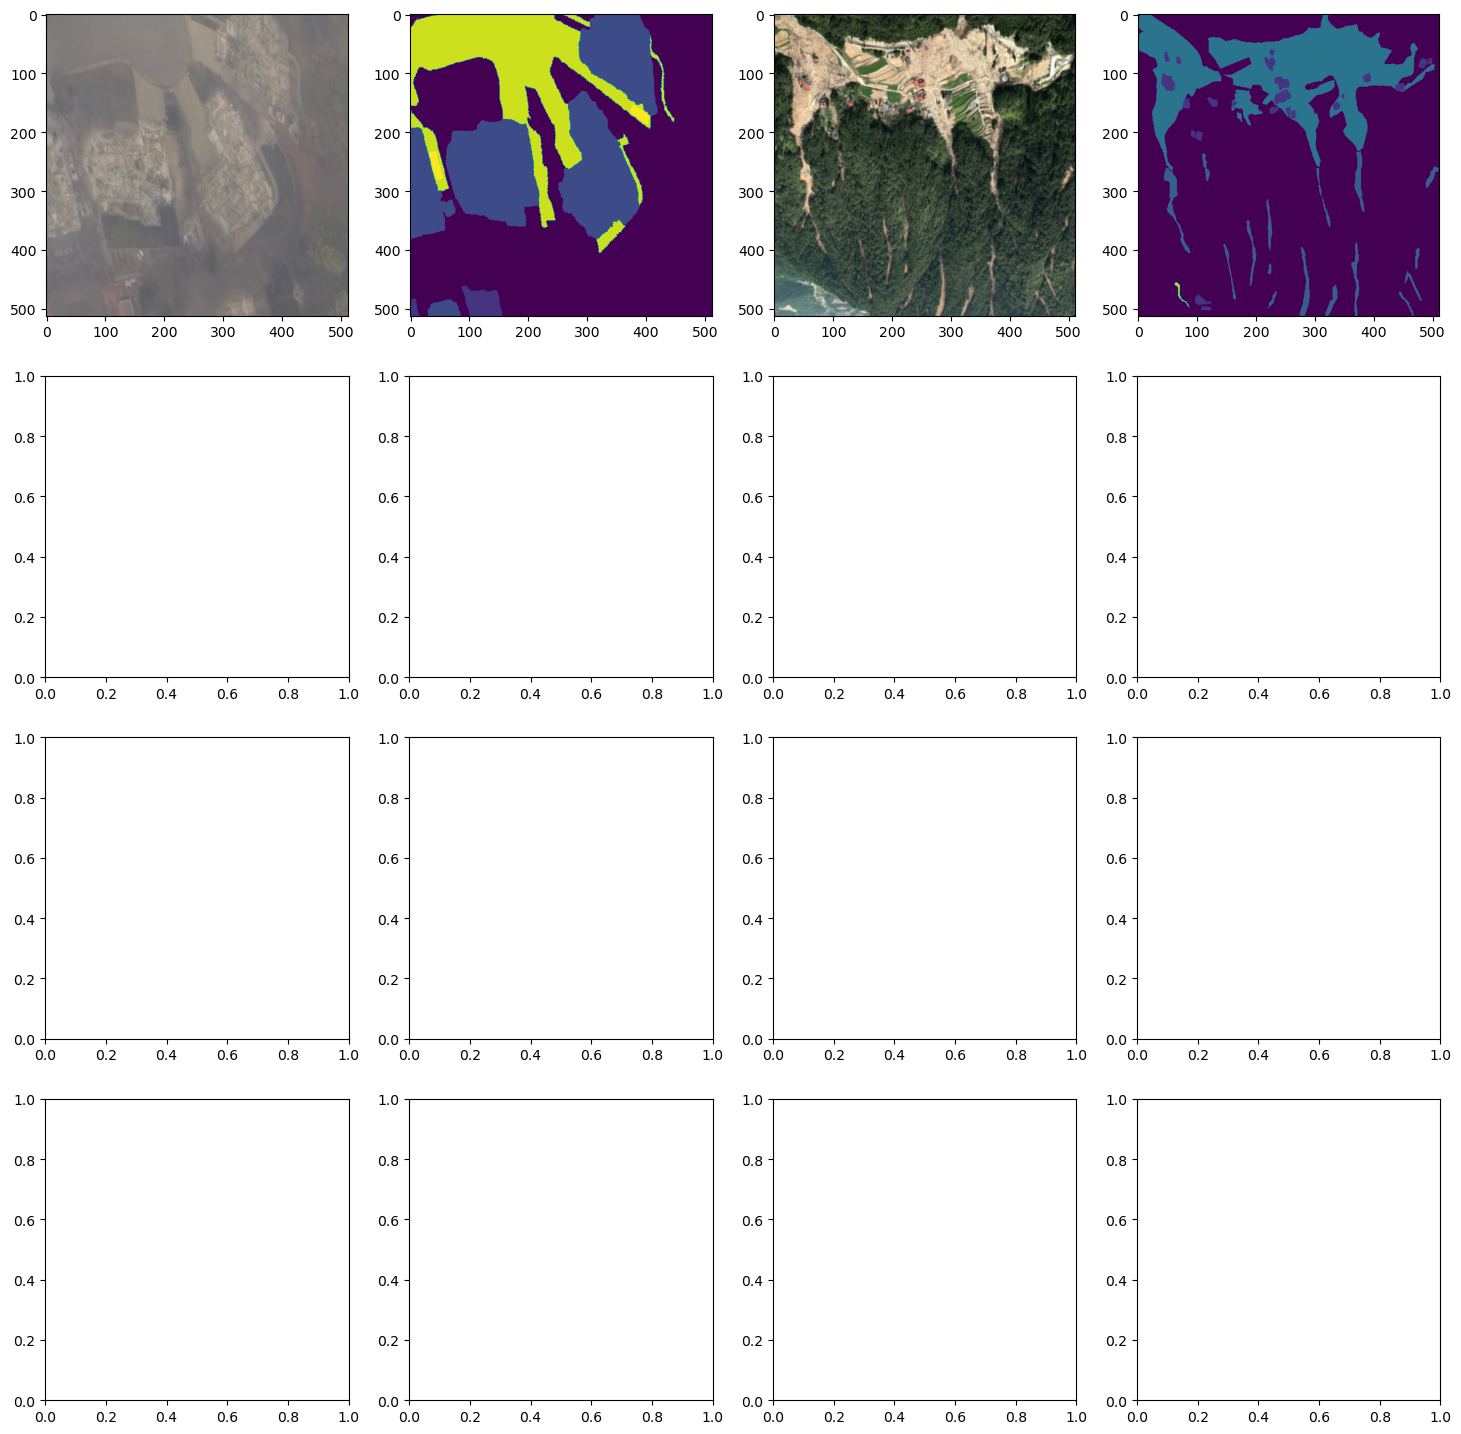

In [15]:
# check org img and label

iterator = iter(train_loader)
imgs, masks = next(iterator)
print(imgs.shape, masks.shape)
print(imgs.dtype)

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(18,18))

count = 0
for r in range(TRAIN_BATCH_SIZE//2):
    axs[r,0].imshow(imgs[count].permute(1,2,0))
    print(np.argmax(masks[count], axis=0))
    axs[r,1].imshow(np.argmax(masks[count], axis=0), vmin = 0, vmax = 13)
    count += 1
    axs[r,2].imshow(imgs[count].permute(1,2,0))
    axs[r,3].imshow(np.argmax(masks[count], axis=0), vmin = 0, vmax = 13)
    count += 1

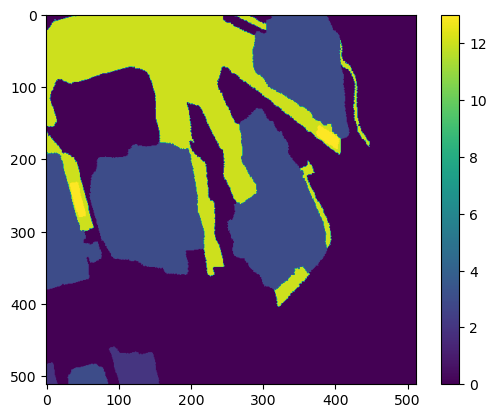

In [16]:
plt.imshow(np.argmax(masks[0], axis=0), vmin = 0, vmax = 13)
plt.colorbar()

In [17]:
#backbone Resnet model code

import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from torch.nn import Module, Conv2d, Parameter, Softmax
import torch.nn.functional as F
from torch.nn.functional import upsample,normalize, interpolate
import logging

BatchNorm = nn.BatchNorm2d

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = BatchNorm(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = BatchNorm(64)
            self.conv2 = conv3x3(64, 64)
            self.bn2 = BatchNorm(64)
            self.conv3 = conv3x3(64, 128)
            self.bn3 = BatchNorm(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(7, stride=1)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        model_path = './initmodel/resnet50_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        try:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet101']), strict=False)
        except RuntimeError as e:
            print('Ignoring "' + str(e) + '"')        
#         model.load_state_dict(model_zoo.load_url(model_urls['resnet101']), strict=False)
#         model_path = './initmodel/resnet101_v2.pth'
#         model.load_state_dict(torch.load(model_path), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
        model_path = './initmodel/resnet152_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model

In [18]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.logger = logging.getLogger(self.__class__.__name__)

    def forward(self):
        raise NotImplementedError

    def summary(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        nbr_params = sum([np.prod(p.size()) for p in model_parameters])
        #self.logger.info(f'Nbr of trainable parameters: {nbr_params}')

    def __str__(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        nbr_params = sum([np.prod(p.size()) for p in model_parameters])
        return super(BaseModel, self).__str__() + f'\nNbr of trainable parameters: {nbr_params}'
        #return summary(self, input_shape=(2, 3, 224, 224))

In [19]:
#encoder for unet
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder, self).__init__()
        self.down_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, ceil_mode=True)

    def forward(self, x):
        x = self.down_conv(x)
        x_pooled = self.pool(x)
        return x, x_pooled

#decoder for unet
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.up_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_copy, x, interpolate=True):
        x = self.up(x)
        if interpolate:
            # Iterpolating instead of padding gives better results
            x = F.interpolate(x, size=(x_copy.size(2), x_copy.size(3)),
                              mode="bilinear", align_corners=True)
        else:
            # Padding in case the incomping volumes are of different sizes
            diffY = x_copy.size()[2] - x.size()[2]
            diffX = x_copy.size()[3] - x.size()[3]
            x = F.pad(x, (diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2))
        # Concatenate
        x = torch.cat([x_copy, x], dim=1)
        x = self.up_conv(x)
        return x

class MUNet(BaseModel):
    def __init__(self, num_classes, in_channels=3, freeze_bn=False, **_):
        super(MUNet, self).__init__()
        self.down1 = encoder(in_channels, 64)
        self.down2 = encoder(64, 128)
        self.down3 = encoder(128, 256)
        #self.down4 = encoder(256, 512)
        self.middle_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.up1 = decoder(512, 256)
        self.up2 = decoder(256, 128)
        self.up3 = decoder(128, 64)
        #self.up4 = decoder(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self._initialize_weights()
        if freeze_bn: self.freeze_bn()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

    def forward(self, x):
        x1, x = self.down1(x)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        #x4, x = self.down4(x)
        x = self.middle_conv(x)
        x = self.up1(x3, x)
        x = self.up2(x2, x)
        x = self.up3(x1, x)
        #x = self.up4(x1, x)
        x = self.final_conv(x)
        return x

    def get_backbone_params(self):
        # There is no backbone for unet, all the parameters are trained from scratch
        return []

    def get_decoder_params(self):
        return self.parameters()

    def freeze_bn(self):
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d): module.eval()

In [20]:
#REDNetPlus

up_kwargs = {'mode': 'bilinear', 'align_corners': True}


class BaseNet(nn.Module):
    def __init__(self, nclass, backbone='resnet50', aux=False, se_loss=False, dilated=True, norm_layer=None,
                 root='./initmodel',
                 multi_grid=False, multi_dilation=None):
        super(BaseNet, self).__init__()
        self.nclass = nclass
        self.aux = aux
        self.se_loss = se_loss
#         self.mean = mean
#         self.std = std
#         self.base_size = base_size
#         self.crop_size = crop_size
        # copying modules from pretrained models
        if backbone == 'resnet50':
            self.pretrained = resnet50(pretrained=False)
        elif backbone == 'resnet101':
            self.pretrained = resnet101(pretrained=False)
        elif backbone == 'resnet152':
            self.pretrained = resnet.resnet152(pretrained=True, dilated=dilated,
                                               norm_layer=norm_layer, root=root,
                                               multi_grid=multi_grid, multi_dilation=multi_dilation)
        else:
            raise RuntimeError('unknown backbone: {}'.format(backbone))
        # bilinear upsample options
        self._up_kwargs = up_kwargs

        self.layer0 = nn.Sequential(self.pretrained.conv1, self.pretrained.bn1, self.pretrained.relu, self.pretrained.conv2, self.pretrained.bn2, self.pretrained.relu, self.pretrained.conv3, self.pretrained.bn3, self.pretrained.relu, self.pretrained.maxpool)

    def base_forward(self, x):
        x = self.layer0(x)
        c1 = self.pretrained.layer1(x)
        c2 = self.pretrained.layer2(c1)
        c3 = self.pretrained.layer3(c2)
        c4 = self.pretrained.layer4(c3)
        return c1, c2, c3, c4

#     def evaluate(self, x, target=None):
#         pred = self.forward(x)
#         if isinstance(pred, (tuple, list)):
#             pred = pred[0]
#         if target is None:
#             return pred
#         correct, labeled = batch_pix_accuracy(pred.data, target.data)
#         inter, union = batch_intersection_union(pred.data, target.data, self.nclass)
#         return correct, labeled, inter, union

class ReDNetPlus(BaseNet):
    def __init__(self, nclass=N_CLASSES, backbone='resnet50', aux=False, se_loss=False, norm_layer=nn.BatchNorm2d, 
                 **kwargs):
        super(ReDNetPlus, self).__init__(nclass, backbone, aux, se_loss, norm_layer=norm_layer, **kwargs)
        self.head = REDNetHead(1024, nclass, norm_layer)
        self.head2 = REDNetHead(2048, nclass, norm_layer)
        
        self.upsample_11 = nn.Upsample(scale_factor=2, mode="bilinear")

        self.conv5c = nn.Sequential(nn.Conv2d(1024, 256, 3, padding=1, bias=False),
                                   norm_layer(256),
                                   nn.ReLU())
        
        self.conv5a = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1, bias=False),
                                   norm_layer(128),
                                   nn.ReLU())

        self.sc = Attention_Mod(256)
        self.sa = Attention_Mod(128)

        self.conv52 = nn.Sequential(nn.Conv2d(256, 256, 3, padding=1, bias=False),
                                   norm_layer(256),
                                   nn.ReLU())
        self.conv51 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1, bias=False),
                                   norm_layer(256),
                                   nn.ReLU())

        self.conv7 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(256, nclass, 1))
        self.conv6 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(256, nclass, 1))

        self.conv8 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(512, nclass, 1))

        self.global_context = GlobalPooling(2048, 256, norm_layer, self._up_kwargs)
        self.munet = MUNet(num_classes=256)

    def forward(self, x):
        imsize = x.size()[2:]
        c1, c2, c3, c4 = self.base_forward(x)

        feat1 = self.conv5a(c2)
        sa_feat = self.sa(feat1)
        sa_conv = self.conv51(sa_feat)
        sa_output = self.conv6(sa_conv)
        

        feat2 = self.conv5c(c3)
        
        sc_feat = self.sc(feat2)
        sc_conv = self.conv52(sc_feat)
        sc_output = self.conv7(sc_conv)

        sc_conv = self.upsample_11(sc_conv)
        feat_sum = sa_conv+sc_conv
        feat_sum = upsample(feat_sum, imsize, **self._up_kwargs)

        ## mini UNet implementation
        munet_output = self.munet(x)
        munet_output = upsample(munet_output, imsize, **self._up_kwargs)

        final_output_tensor = torch.cat((feat_sum, munet_output), 1)
        final_output = self.conv8(final_output_tensor)

        return final_output


class GlobalPooling(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer, up_kwargs):
        super(GlobalPooling, self).__init__()
        self._up_kwargs = up_kwargs
        self.gap = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                 nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                 norm_layer(out_channels),
                                 nn.ReLU(True))

    def forward(self, x):
        _, _, h, w = x.size()
        pool = self.gap(x)
        return interpolate(pool, (h,w), **self._up_kwargs)

class REDNetHead(nn.Module):
    def __init__(self, in_channels, out_channels, norm_layer):
        super(REDNetHead, self).__init__()
        inter_channels = in_channels // 4
        self.conv5a = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                   norm_layer(inter_channels),
                                   nn.ReLU())
        
        self.conv5c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                   norm_layer(inter_channels),
                                   nn.ReLU())

        self.sa = Attention_Mod(inter_channels)
        #self.sc = CAM_Module(inter_channels)
        self.conv51 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False),
                                   norm_layer(inter_channels),
                                   nn.ReLU())
        self.conv52 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False),
                                   norm_layer(inter_channels),
                                   nn.ReLU())

        self.conv6 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(inter_channels, out_channels, 1))
        self.conv7 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(inter_channels, out_channels, 1))

        self.conv8 = nn.Sequential(nn.Dropout2d(0.1, False), nn.Conv2d(inter_channels, out_channels, 1))

    def forward(self, x1):
        feat1 = self.conv5a(x1)
        sa_feat = self.sa(feat1)
        sa_conv = self.conv51(sa_feat)
        sa_output = self.conv6(sa_conv)

        return sa_output


class Attention_Mod(Module):
    """ Attention Module """
    def __init__(self, in_dim):
        super(Attention_Mod, self).__init__()
        self.channel_in = in_dim

        self.query_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = Parameter(torch.zeros(1))
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        """
            input: 
                x : input feature maps (B x C x H x W)
            returns:
                out : attention value + input feature
                attention: B x (HxW) x (HxW)
        """

        m_batchsize, m_channel, m_height, m_width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, m_width*m_height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, m_width*m_height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, m_width*m_height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, m_channel, m_height, m_width)

        out = self.gamma*out + x
        return out

In [ ]:
model = ReDNetPlus().to(DEVICE)

In [ ]:
summary.summary(model, (TRAIN_IMG_SIZE[2],TRAIN_IMG_SIZE[0],TRAIN_IMG_SIZE[1]))

In [21]:
import numpy as np


class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [22]:
import sys
import torch
from tqdm import tqdm as tqdm



class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}
        loss_val = 0
        metric_val = []
        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_val = loss_meter.mean
                loss_logs = {self.loss.__name__: loss_val}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                    metric_val.append(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs,loss_val, metric_val


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [23]:
import re
import torch.nn as nn


class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)

In [24]:
import torch.nn.functional as F
class mIoU(Metric):
    def __init__(self, num_classes, eps=1e-7):
        super(mIoU, self).__init__()
        self.eps = eps
        self.num_classes = num_classes
        self.iou_scores = torch.zeros(num_classes)

    def forward(self, y_pred, y_true):
        #print(y_pred.shape)
        #print(y_true.shape)
        y_pred = F.softmax(y_pred, dim=1)
        #print(" max y_pred",y_pred.shape)
        #y_true = F.one_hot(y_true, num_classes=self.num_classes).permute(0, 3, 1, 2)
        #print(y_true.shape)
        #print(y_pred[:, 0, :, :])
        iou_scores = []
        for i in range(self.num_classes):
            intersection = torch.sum(y_pred[:, i, :, :] * y_true[:, i, :, :])
            union = torch.sum(y_pred[:, i, :, :]) + torch.sum(y_true[:, i, :, :]) - intersection
            iou_i = (intersection + self.eps) / (union + self.eps)
            iou_scores.append(iou_i.item())
        self.iou_scores = torch.tensor(iou_scores)
        miou = torch.mean(self.iou_scores)
        return miou

In [25]:
import torch.nn.functional as F
class DiceScore(Metric):
    def __init__(self, num_classes, eps=1e-7):
        super(DiceScore, self).__init__()
        self.eps = eps
        self.num_classes = num_classes
        self.iou_scores = torch.zeros(num_classes)

    def forward(self, y_pred, y_true):
        #print(y_pred.shape)
        #print(y_true.shape)
        y_pred = F.softmax(y_pred, dim=1)
        #print(" max y_pred",y_pred.shape)
        #y_true = F.one_hot(y_true, num_classes=self.num_classes).permute(0, 3, 1, 2)
        #print(y_true.shape)
        dice_scores = []
        #print(y_true[:,0,:,:])
        for i in range(self.num_classes):
            intersection = torch.sum(y_pred[:, i, :, :] * y_true[:, i, :, :])
            union = torch.sum(y_pred[:, i, :, :]) + torch.sum(y_true[:, i, :, :]) + intersection
            dice = (2 * intersection + self.eps) / (union + self.eps)
            dice_scores.append(dice.item())
        self.dice_scores = torch.tensor(dice_scores)
        mdice = torch.mean(self.dice_scores)
        return mdice

In [ ]:
import segmentation_models_pytorch.utils.metrics

loss_fn = smp.losses.dice.DiceLoss(mode='multilabel',classes=N_CLASSES)

loss_fn.__name__ = 'Dice_loss'

#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay )
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
# Dice_score = torchmetrics.Dice(num_classes=N_CLASSES)
# Dice_score.__name__ = 'Dice_score'
#mIou = mIoU(ConfusionMatrix(num_classes=N_CLASSES),ignore_index=0)
#mIou.__name__ = 'mIoU'
#metric : ( Dice_confi = 1 - Dice_loss )
metric = [mIoU(N_CLASSES),DiceScore(N_CLASSES)]

train_one_epoch = TrainEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

val_one_epoch = ValidEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    device=DEVICE,
    verbose=True
)

In [26]:
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print("=> Saving checkpoint")
    torch.save(obj=state, f=filename)


def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

In [ ]:
if LOAD_MODEL:
    load_checkpoint('./REDNETPLUS-resnet101-after-300-epochs.pth', model)

import torch
from torch.utils.tensorboard import SummaryWriter
writer = writer = SummaryWriter()
    

#train
for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):
    print("EPOCH ", epoch)
    train_logs,loss_val, metric_list = train_one_epoch.run(dataloader=train_loader)
    print(train_logs)
    writer.add_scalar('Loss/train/dice_loss',loss_val,epoch)
    writer.add_scalar('Metirc/train/mIoU',metric_list[0],epoch)
    writer.add_scalar('Metirc/train/mean_dice_socre',metric_list[1],epoch)
    
    val_logs,val_loss_val, val_metric_list = val_one_epoch.run(dataloader=val_loader)
    writer.add_scalar('Loss/val/dice_loss',val_loss_val,epoch)
    writer.add_scalar('Metirc/val/mIoU',val_metric_list[0],epoch)
    writer.add_scalar('Metirc/val/mean_dice_socre',val_metric_list[1],epoch)
    print(val_logs)
    
    torch.save(model.state_dict(), './REDNETPLUS-resnet101-after-500-epochs.pth')

In [ ]:
writer.flush()

In [ ]:
writer.close()

In [ ]:
#!python3 -m tensorboard.main --logdir=runs

In [27]:
iterator = iter(test_loader)

In [28]:
model_basic = ReDNetPlus().to(DEVICE)
load_checkpoint('REDNETPLUS-original-after-300-epochs.pth', model_basic)

=> Loading checkpoint


/home/sangho/anaconda3/envs/lpcv/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


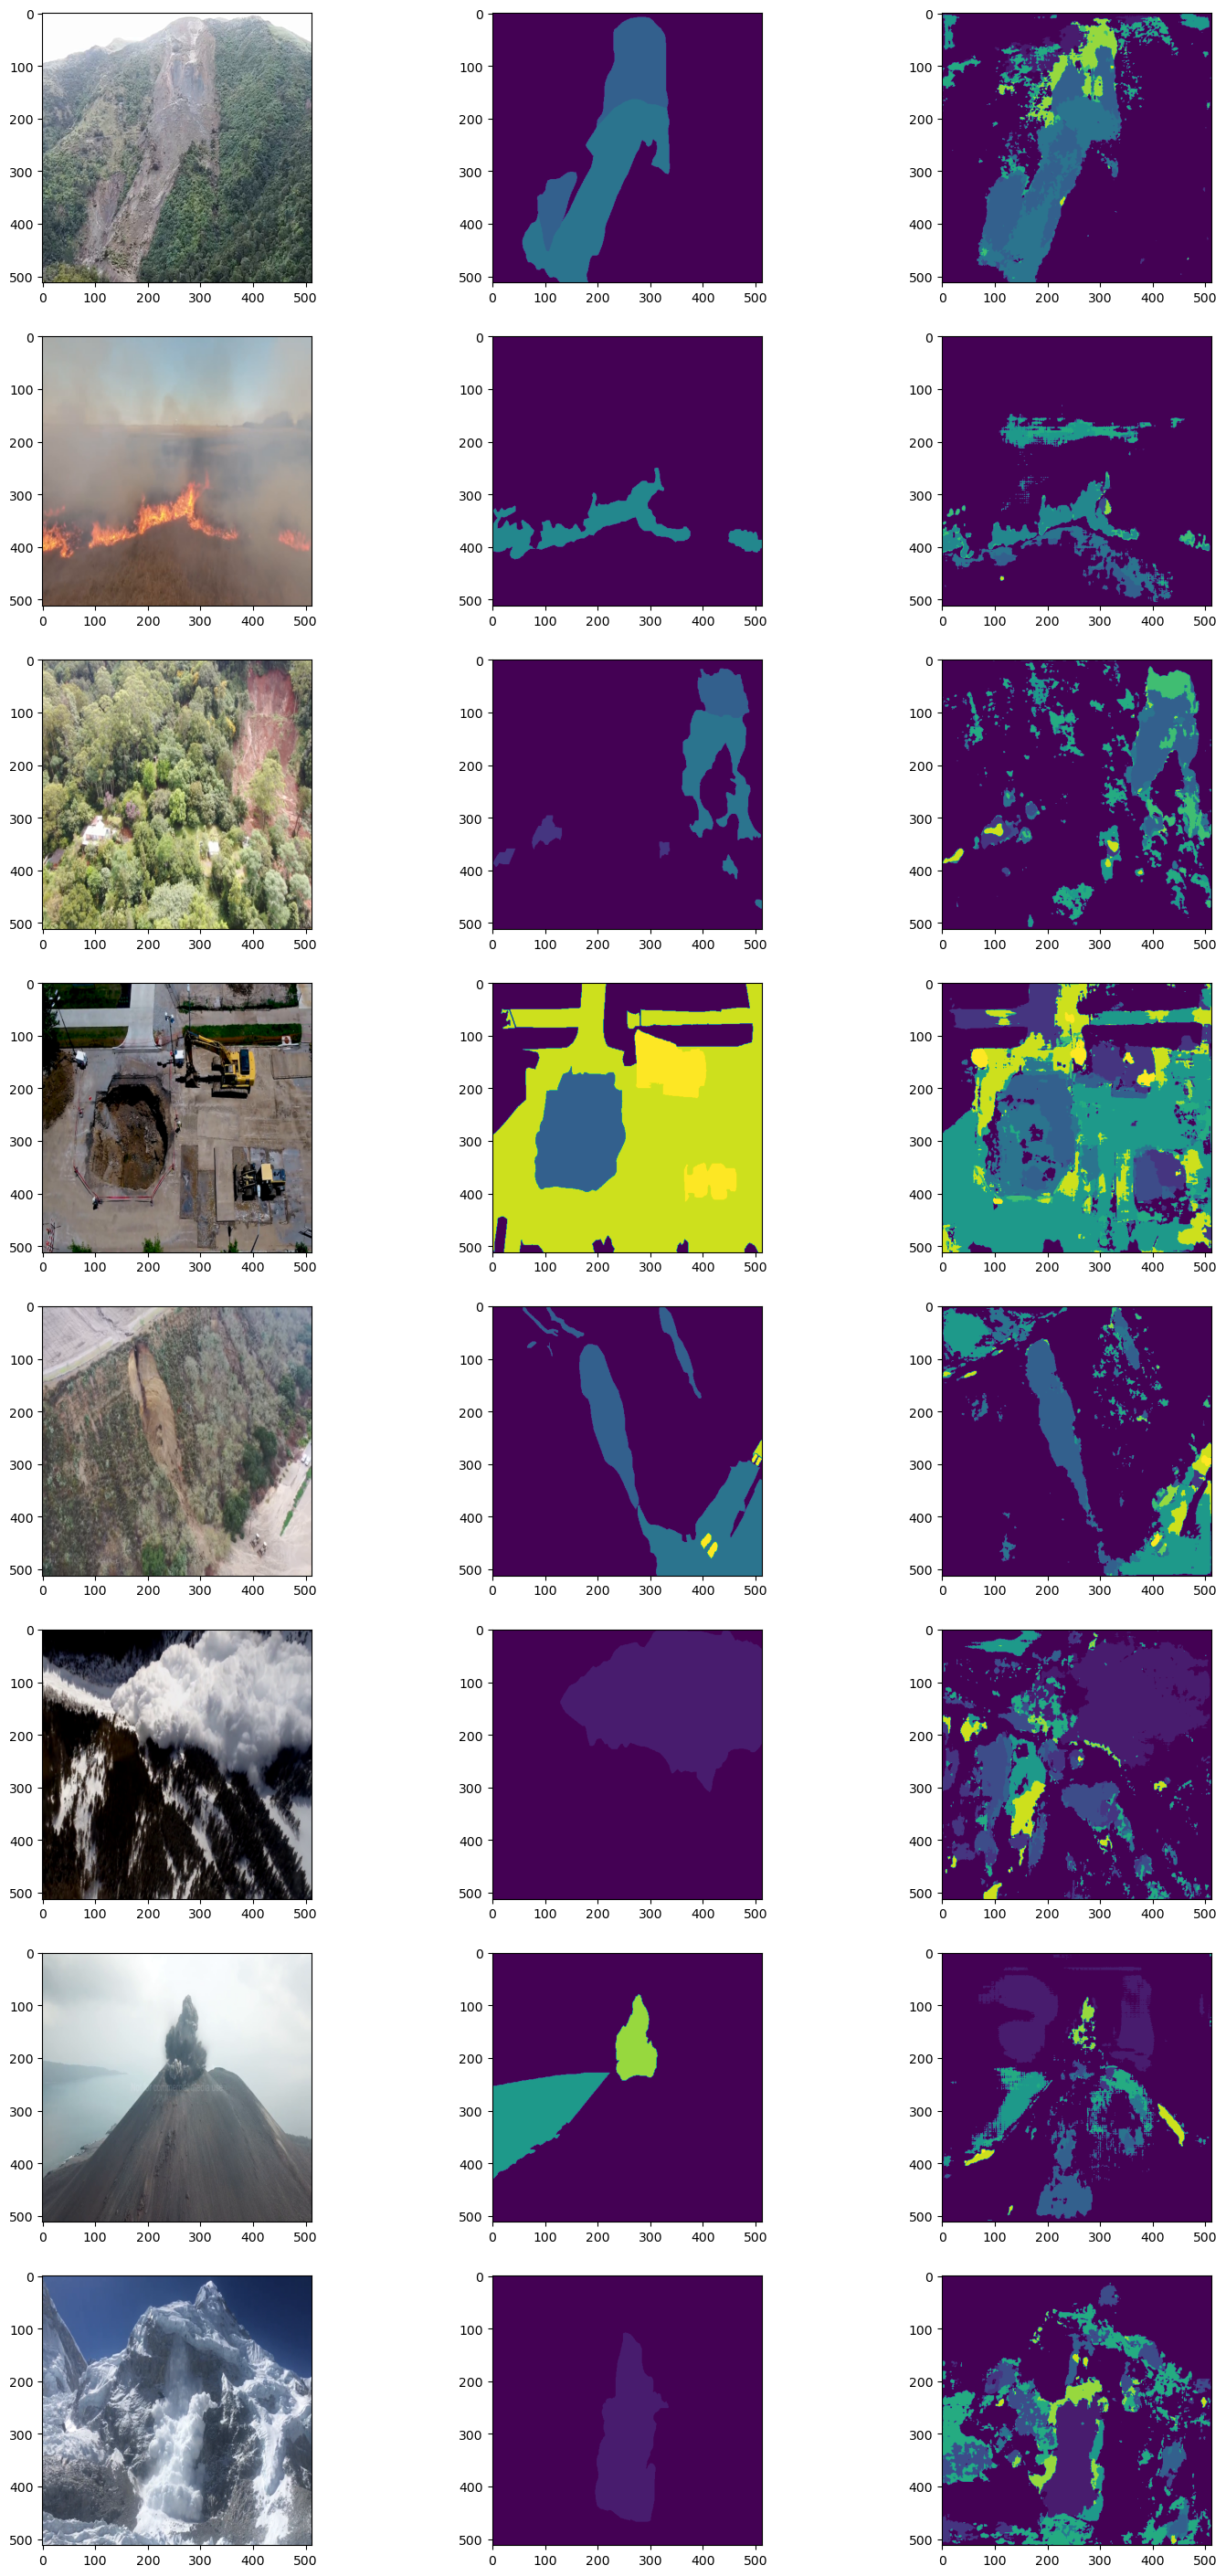

In [29]:
fig, axs = plt.subplots(nrows=8, ncols=3,figsize=(18,36))


for count in range(8):
    imgs, masks = next(iterator)
    preds = model_basic(imgs.to(DEVICE))
    axs[count,0].imshow(imgs[0].permute(1,2,0))
    axs[count,1].imshow(np.argmax(masks[0], axis=0), vmin = 0, vmax = 13)
    axs[count,2].imshow(np.argmax(preds[0].cpu().detach().numpy(), axis=0), vmin = 0, vmax = 13)

In [30]:
from sklearn.metrics import confusion_matrix

def evaluate_segmentation_model(model, dataloader, num_classes):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings=np.zeros((100,1))  
    total_time = 0
    model.eval()
    with torch.no_grad():
        total_ious = []
        total_dices = []
        for img, target in iter(dataloader):
            img = img.cuda()
            target = target.cuda()
            
            torch.cuda.synchronize()
            starter.record()
            output = model(img)
            torch.cuda.synchronize()
            
            ender.record()
            
            curr_time = starter.elapsed_time(ender)
            timings = np.append(timings, curr_time)
            #수정 요함
            #timings = np.append(timings, starter.elapsed_time(ender))
            
            output = torch.argmax(output, dim=1)
            #print(output.shape)

            ious = []
            dices = []
            for cls in range(num_classes):
                tp = ((output[0,:,:] == cls) & (target == cls)).sum().item()
                fp = ((output[0,:,:] == cls) & (target != cls)).sum().item()
                fn = ((output[0,:,:] != cls) & (target == cls)).sum().item()
                union = tp + fp + fn
                iou = tp / (union + 1e-10)
                dice = 2 * tp / (2 * tp + fp + fn + 1e-10)
                ious.append(iou)
                dices.append(dice)

            total_ious.append(np.mean(ious))
            total_dices.append(np.mean(dices))

    miou = np.mean(total_ious)
    dice_score = np.mean(total_dices)
    total_time = np.sum(timings)
    mean_total_time = np.mean(timings)

    return miou, dice_score, total_time, mean_total_time

In [33]:
miou, dice_score, total_time, mean_total_time = evaluate_segmentation_model(model_basic, test_loader, 13)
print("resnet50-ReDnetPlus-300epoch")
print("mIoU:", miou)
print("Dice score:", dice_score)
print("total_time:", total_time, " ms")
print("mean_total_time :", mean_total_time, " ms")

resnet50-ReDnetPlus-300epoch
mIoU: 0.05281297933575253
Dice score: 0.061667761012618276
total_time: 4061.7492485046387  ms
mean_total_time : 20.308746242523192  ms
